In [3]:
!module load cuda/12.1

In [41]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.spatial import KDTree

PI  = torch.pi
TWO_PI = 2.0 * torch.pi

# ---- Angle wrapping helpers ----
def wrap_to_pi(a: torch.Tensor) -> torch.Tensor:
    """Wrap to (-pi, pi]. Robust via atan2(sin,cos)."""
    return torch.atan2(torch.sin(a), torch.cos(a))

def wrap_to_0_2pi(a: torch.Tensor) -> torch.Tensor:
    """Wrap to [0, 2pi)."""
    w = torch.remainder(a, TWO_PI)
    return torch.where(w < 0, w + TWO_PI, w)

In [73]:
"""
Active Brownian Particles with anisotropic "shape" interaction (via exp(-W/W0)),
k-NN neighbor list (SciPy cKDTree), overdamped Langevin + self-propulsion,
and a **soft exponential circular wall**.

Circular wall (center c, radius R):
  Let r = ||x - c||, inward distance d = R - r  (>=0 inside the circle).
  U_wall(d) = U0 * exp(- d / lambda_w)
  F_wall    = - (U0 / lambda_w) * exp(- d / lambda_w) * r_hat   (points toward center),
  where r_hat = (x - c)/r, with F=0 at r≈0 for numerical safety.

Pair interaction:
  U_ij = exp( - W_ij / W0 ),  W_ij = ||x_i - x_j||^2 + W_cov(l_i, phi_i; l_j, phi_j; l0)
  det-covs = l0^4, eigenvalues (l^2, l0^4 / l^2) oriented by phi.

Self-propulsion: v0 * u(theta_i), theta has rotational diffusion (Euler–Maruyama).

All tensors kept on CPU (SciPy KDTree).
"""

import numpy as np
import torch
from scipy.spatial import cKDTree
from typing import Tuple, Dict

# -----------------------------
# k-NN neighbor search (SciPy KDTree)
# -----------------------------
def knn_edges_from_kdtree(pos: torch.Tensor, k: int) -> torch.Tensor:
    """
    Build directed edge list (2,E) where each node i connects to its k nearest neighbors j (j != i).
    Uses SciPy cKDTree on CPU; returns tensor on `pos.device`.
    """
    assert k >= 1
    device = pos.device
    cpu_pos = pos.detach().cpu().numpy()
    tree = cKDTree(cpu_pos)
    # Query k+1 to include self (distance 0). We'll drop self column (self index).
    dists, idx = tree.query(cpu_pos, k=k+1, workers=-1)  # (N, k+1)
    idx = idx[:, 1:]  # drop self
    N = idx.shape[0]
    src = np.repeat(np.arange(N, dtype=np.int64), k)
    dst = idx.reshape(-1).astype(np.int64)
    ei = torch.tensor(np.stack([src, dst], axis=0), dtype=torch.long, device=device)
    return ei

# -----------------------------
# Covariance W term (vectorized over edges)
# -----------------------------
def wasserstein_cov_term(l0: float,
                         l_i: torch.Tensor, phi_i: torch.Tensor,
                         l_j: torch.Tensor, phi_j: torch.Tensor,
                         eps: float = 1e-12) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    l0: scalar >0 (float)
    l_i, phi_i, l_j, phi_j: (E,) tensors for edges (i->j)
    Returns:
      Wcov: (E,), term: (E,), root: (E,)
    """
    g0 = l0 * l0  # = ell_0^2
    x = (l_i * l_i) / (g0 + eps)   # dimensionless
    y = (l_j * l_j) / (g0 + eps)

    d = phi_i - phi_j
    c = torch.cos(d); s = torch.sin(d)
    c2 = c * c; s2 = s * s

    xy = x * y
    inv_xy = 1.0 / (xy + eps)
    y_over_x = y / (x + eps)
    x_over_y = x / (y + eps)

    term = c2 * (xy + inv_xy) + s2 * (y_over_x + x_over_y) + 2.0
    root = torch.sqrt(term)
    Wcov = g0 * ((x + 1.0 / (x + eps)) + (y + 1.0 / (y + eps)) - 2.0 * root)
    return Wcov, term, root

# -----------------------------
# Pair energy and position forces
# -----------------------------
def pair_energy_and_forces(pos: torch.Tensor,
                           l: torch.Tensor, phi: torch.Tensor,
                           l0: float, W0: float,
                           edge_index: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    pos: (N,2), l:(N,), phi:(N,) (same device & dtype)
    edge_index: (2,E) long (directed)
    Returns:
      U_edges: (E,), W_edges: (E,), forces: (N,2)
    Note: force is only from the position (r^2) part of W (as intended).
    """
    i, j = edge_index
    rij = pos[i] - pos[j]                      # (E,2)
    r2 = (rij * rij).sum(dim=-1)               # (E,)

    Wcov, _, _ = wasserstein_cov_term(l0, l[i], phi[i], l[j], phi[j])
    W_edges = r2 + Wcov
    U_edges = torch.exp(-W_edges / W0)

    # Force on i from j (distance part): F_ij = (U/W0) * 2 * (x_i - x_j)
    F_ij = (U_edges / W0).unsqueeze(-1) * (2.0 * rij)  # (E,2)

    # scatter to nodes
    N = pos.shape[0]
    forces = torch.zeros_like(pos)
    forces.index_add_(0, i, F_ij)
    forces.index_add_(0, j, -F_ij)  # Newton's 3rd (symmetrize)

    return U_edges, W_edges, forces

def evolve_shape_parameters(l, phi, l0, W0, pos, edge_index, eta_l, eta_phi, dt):
    # Compute pair-level quantities (reuse same code as for forces)
    i, j = edge_index
    Wcov, term, root = wasserstein_cov_term(l0, l[i], phi[i], l[j], phi[j])
    g0 = l0*l0
    x = (l[i]*l[i])/g0
    y = (l[j]*l[j])/g0
    d = phi[i]-phi[j]
    c = torch.cos(d); s = torch.sin(d)
    c2=c*c; s2=s*s
    xy = x*y; inv_x=1/x; inv_y=1/y
    inv_x2=inv_x*inv_x
    B1 = xy + 1/xy
    B2 = y/x + x/y

    # dW/dx_i  (dimensionless)
    dterm_dx = c2*(y - 1/(x*x*y)) + s2*(-y/x**2 + 1/y)
    dWdx = g0*(1 - 1/x**2 - dterm_dx/(root+1e-12))
    dWdl_edge = dWdx * (2*l[i]/g0)
    dterm_dd  = (2*s*c)*(B2-B1)
    dWdphi_edge = -g0 * dterm_dd/(root+1e-12)

    # U = exp(-W/W0)
    U_edges = torch.exp(-( (pos[i]-pos[j]).pow(2).sum(-1) + Wcov ) / W0)
    coeff = (U_edges/W0)

    # accumulate gradients (sum over j)
    dl_i = torch.zeros_like(l)
    dphi_i = torch.zeros_like(phi)
    dl_i.index_add_(0, i, coeff * dWdl_edge)
    dphi_i.index_add_(0, i, coeff * dWdphi_edge)

    # overdamped updates
    xi_l = torch.randn_like(l)
    xi_phi = torch.randn_like(phi)
    l = l - dt*eta_l*dl_i
    phi = phi - dt*eta_phi*dphi_i
    return l, phi

# -----------------------------
# Circular wall potential
# -----------------------------
def circular_wall_energy_and_forces(pos: torch.Tensor,
                                    R: float,
                                    U0: float,
                                    lambda_w: float,
                                    center: Tuple[float, float] = (0.0, 0.0)
                                   ) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Soft exponential circular wall: interior radius R around 'center'.

    Let r = ||x - c||, inward distance d = R - r. For particles inside (d>=0),
      U_wall = U0 * exp(- d / lambda_w),
      F_wall = - (U0 / lambda_w) * exp(- d / lambda_w) * r_hat,  r_hat = (x - c)/r.
    For numerical robustness, at r≈0 set F=0 (no preferred direction).

    Returns:
      U_wall_per_particle: (N,)
      F_wall: (N,2)
    """
    c = torch.tensor(center, dtype=pos.dtype, device=pos.device).view(1, 2)
    v = pos - c                      # (N,2)
    r = torch.linalg.norm(v, dim=-1) # (N,)
    # inward distance (>=0 inside, <0 outside). We can apply to all r, but the force form still makes sense.
    d = R - r

    e = torch.exp(-d / lambda_w)     # (N,)
    U = U0 * e

    # normalized radial direction; handle r≈0
    eps = 1e-12
    r_safe = torch.clamp(r, min=eps)
    r_hat = v / r_safe.unsqueeze(-1)       # (N,2)
    F = - (U0 / lambda_w) * e.unsqueeze(-1) * r_hat
    # zero force exactly at r=0 to avoid NaNs
    F[r <= eps] = 0.0
    return U, F

# -----------------------------
# Simulation step (Langevin + self-propulsion + circular wall)
# -----------------------------
@torch.no_grad()
def simulate_step_knn_circular_wall(pos: torch.Tensor, theta: torch.Tensor,
                                    l: torch.Tensor, phi: torch.Tensor,
                                    l0: float, W0: float,
                                    v0: float, D_t: float, D_r: float,
                                    k_nn: int, dt: float,
                                    R: float, U0_wall: float, lambda_wall: float,
                                    center: Tuple[float, float] = (0.0, 0.0)
                                   ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, Dict]:
    """
    pos: (N,2), theta:(N,), l:(N,), phi:(N,)  [tensors on CPU for KDTree]
    Circular wall of radius R centered at 'center'.
    Returns updated (pos, theta, edge_index, diagnostics)
    """
    # k-NN neighbor list (SciPy KDTree)
    edge_index = knn_edges_from_kdtree(pos, k=k_nn)

    # Pair forces from potential (position part)
    Ue, We, F_pairs = pair_energy_and_forces(pos, l, phi, l0, W0, edge_index)

    # Circular wall forces
    Uwall, F_wall = circular_wall_energy_and_forces(pos, R, U0_wall, lambda_wall, center=center)

    # Self-propulsion drift
    u = torch.stack([torch.cos(theta), torch.sin(theta)], dim=-1)  # (N,2)

    # Total drift
    drift = F_pairs + F_wall + v0 * u  # (N,2)

    # Overdamped Langevin (Euler–Maruyama)
    if D_t > 0.0:
        xi = torch.randn_like(pos)
        pos = pos + dt * drift + torch.sqrt(torch.tensor(2.0 * D_t * dt, dtype=pos.dtype, device=pos.device)) * xi
    else:
        pos = pos + dt * drift

    # Rotational diffusion
    if D_r > 0.0:
        eta = torch.randn_like(theta)
        theta = theta + torch.sqrt(torch.tensor(2.0 * D_r * dt, dtype=theta.dtype, device=theta.device)) * eta
    
    theta = wrap_to_0_2pi(theta)
    

    l, phi = evolve_shape_parameters(l, phi, l0, W0, pos, edge_index,
                                 eta_l=1e-2, eta_phi=1e-2,
                                 dt=dt)
    phi = wrap_to_pi(phi)
    # Diagnostics
    U_pairs_total_directed = Ue.sum()  # directed edges sum
    U_wall_total = Uwall.sum()
    diag = {
        "num_edges": edge_index.shape[1],
        "U_pairs_directed_sum": U_pairs_total_directed.item(),
        "U_wall_sum": U_wall_total.item(),
        "U_mean_pairs_per_node": (U_pairs_total_directed / pos.shape[0]).item(),
        "U_wall_mean_per_node": (U_wall_total / pos.shape[0]).item(),
    }
    return pos, theta, l, phi, edge_index, diag



    

In [78]:
# Parameters
N       = 512
R       = 25.0                # circular arena radius
center  = (0.0, 0.0)
l0      = 1.0                 # det scale (det = l0^4)
W0      = 1.0
v0      = 1.0
D_t     = 0.00
D_r     = 0.10
k_nn    = 6                  # k nearest neighbors
dt      = 0.01
steps   = 100000
# Wall parameters
U0_wall     = 5.0             # strength scale
lambda_wall = 1.0             # decay length
# Init (CPU tensors for KDTree)
device = torch.device("cpu")
rng    = torch.Generator(device=device).manual_seed(0)
# Start uniformly inside the circle (rejection sampling)
pos = torch.empty(0, 2, device=device)
while pos.shape[0] < N:
    cand = torch.empty(4*N, 2, device=device).uniform_(-R, R, generator=rng)
    keep = (cand**2).sum(dim=1) <= (R-2.0)**2  # margin from wall
    pos = torch.cat([pos, cand[keep]], dim=0)
pos = pos[:N]
theta = torch.empty(N, device=device).uniform_(0.0, 2.0 * torch.pi, generator=rng)
# Shape parameters (can be heterogeneous)
l   = torch.full((N,), 1.2, device=device)                    # major-axis scale
phi = torch.empty(N, device=device).uniform_(0, 2.0*torch.pi, generator=rng)  # ellipse orientation
for t in range(steps):
    pos, theta, l, phi, edge_index, diag = simulate_step_knn_circular_wall(
        pos, theta, l, phi, l0, W0, v0, D_t, D_r, k_nn, dt,
        R, U0_wall, lambda_wall, center=center
    )
    if (t % 5000) == 0:
        print(f"step {t:04d} | edges {diag['num_edges']} | "
              f"U_pairs_mean/node {diag['U_mean_pairs_per_node']:.4f} | "
              f"U_wall_mean/node {diag['U_wall_mean_per_node']:.4f}")

step 0000 | edges 3072 | U_pairs_mean/node 0.8339 | U_wall_mean/node 0.0527


step 5000 | edges 3072 | U_pairs_mean/node 0.2584 | U_wall_mean/node 0.2735
step 10000 | edges 3072 | U_pairs_mean/node 0.2704 | U_wall_mean/node 0.2722
step 15000 | edges 3072 | U_pairs_mean/node 0.2719 | U_wall_mean/node 0.2770
step 20000 | edges 3072 | U_pairs_mean/node 0.2676 | U_wall_mean/node 0.2780
step 25000 | edges 3072 | U_pairs_mean/node 0.2731 | U_wall_mean/node 0.2642
step 30000 | edges 3072 | U_pairs_mean/node 0.2848 | U_wall_mean/node 0.2957
step 35000 | edges 3072 | U_pairs_mean/node 0.2603 | U_wall_mean/node 0.2655
step 40000 | edges 3072 | U_pairs_mean/node 0.2693 | U_wall_mean/node 0.2672
step 45000 | edges 3072 | U_pairs_mean/node 0.2843 | U_wall_mean/node 0.2839
step 50000 | edges 3072 | U_pairs_mean/node 0.2859 | U_wall_mean/node 0.2800
step 55000 | edges 3072 | U_pairs_mean/node 0.3052 | U_wall_mean/node 0.3182
step 60000 | edges 3072 | U_pairs_mean/node 0.2759 | U_wall_mean/node 0.2876
step 65000 | edges 3072 | U_pairs_mean/node 0.2779 | U_wall_mean/node 0.2862


In [79]:

from matplotlib.patches import Ellipse

def draw_ellipses(ax, pos, l, phi, l0, *,
                  edgecolor="tab:blue", facecolor="none",
                  lw=1.0, alpha=0.9, scale=1.0, zorder=2):
    """
    Draw 1-sigma ellipses for all particles.

    Parameters
    ----------
    ax : matplotlib Axes
    pos : (N,2) array-like (torch or numpy)
    l   : (N,)  array-like
    phi : (N,)  array-like (radians)
    l0  : float
    edgecolor, facecolor : Matplotlib colors
    lw : float (line width)
    alpha : float (patch alpha)
    scale : float (visual scaling of the ellipse radii; 1.0 = 1-sigma)
    zorder : draw order
    """
    # convert to numpy if needed
    if isinstance(pos, torch.Tensor): pos  = pos.detach().cpu().numpy()
    if isinstance(l,   torch.Tensor): l    = l.detach().cpu().numpy()
    if isinstance(phi, torch.Tensor): phi  = phi.detach().cpu().numpy()

    a = scale * l                          # major semi-axis
    b = scale * (l0*l0) / (l + 1e-12)      # minor semi-axis (since det = l0^4)
    angles_deg = np.degrees(phi)           # matplotlib expects degrees

    for (x, y), ai, bi, ang in zip(pos, a, b, angles_deg):
        e = Ellipse((x, y), width=2*ai, height=2*bi, angle=ang,
                    edgecolor=edgecolor, facecolor=facecolor,
                    lw=lw, alpha=alpha, zorder=zorder)
        ax.add_patch(e)

def draw_orientations(ax, pos, phi, length=0.6, color="tab:orange", lw=1.5, zorder=3):
    """
    Draw a short line indicating each particle's ellipse orientation phi.
    """
    if isinstance(pos, torch.Tensor): pos  = pos.detach().cpu().numpy()
    if isinstance(phi, torch.Tensor): phi  = phi.detach().cpu().numpy()

    ux = np.cos(phi); uy = np.sin(phi)
    x0 = pos[:, 0];  y0 = pos[:, 1]
    x1 = x0 + length * ux
    y1 = y0 + length * uy
    for xi, yi, xj, yj in zip(x0, y0, x1, y1):
        ax.plot([xi, xj], [yi, yj], color=color, lw=lw, zorder=zorder)

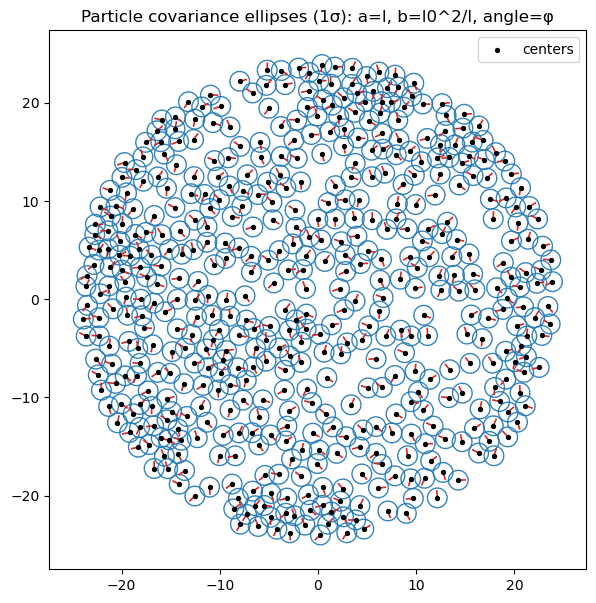

In [81]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(pos[:, 0], pos[:, 1], s=8, c="k", zorder=4, label="centers")
draw_ellipses(ax, pos, l, phi, l0, edgecolor="C0", facecolor="none", lw=1.0, scale=1.0, alpha=0.9)
draw_orientations(ax, pos, phi, length=0.7, color="C3", lw=1.2)
# aesthetics
ax.set_aspect('equal', adjustable='box')
pad = 2.5
ax.set_title("Particle covariance ellipses (1σ): a=l, b=l0^2/l, angle=φ")
ax.legend(loc="upper right")
plt.show()